# **Multi-Label Classification Using Neural Network**

### **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout

### **Input Dataset**

In [2]:
# Input dataset
dataset_url = 'https://raw.githubusercontent.com/adrielgian99/Bangkit-Capstone-C242-PR593/machine_learning/Clean_Dataset/gym_and_diet_recommendation_clean_dataset.csv'

df = pd.read_csv(dataset_url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14552 entries, 0 to 14551
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   14552 non-null  int64  
 1   gender               14552 non-null  object 
 2   age                  14552 non-null  int64  
 3   height               14552 non-null  int64  
 4   weight               14552 non-null  float64
 5   hypertension_status  14552 non-null  object 
 6   diabetes_status      14552 non-null  object 
 7   BMI                  14552 non-null  float64
 8   user_obesity_level   14552 non-null  object 
 9   fitness_goal         14552 non-null  object 
 10  fitness_type         14552 non-null  object 
 11  exercises            14552 non-null  object 
 12  diet                 14552 non-null  object 
 13  vegetables           14552 non-null  object 
 14  protein_intake       14552 non-null  object 
 15  juice                14552 non-null 

In [4]:
df.describe()

,id,age,height,weight,BMI
count,14552.000000,14552.000000,14552.000000,14552.000000,14552.000000
mean,7293.386476,39.515943,169.978766,70.547725,24.430467
std,4212.687264,13.183778,9.818616,20.033364,6.754729
min,1.000000,18.000000,130.000000,32.000000,9.520000
25%,3650.750000,28.000000,164.000000,55.000000,18.960000
50%,7288.500000,39.000000,168.000000,70.000000,25.260000
75%,10938.250000,51.000000,177.000000,86.000000,29.340000
max,14589.000000,63.000000,202.000000,130.000000,57.990000


### **Data Preprocessing**

In [5]:
# One-hot encode categorical columns
categorical_columns1 = ["gender", "hypertension_status", "diabetes_status", "fitness_goal", "fitness_type"]
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoded = onehot_encoder.fit_transform(df[categorical_columns1])
onehotencoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns1))

# Concatenate one-hot encoded features with the original DataFrame
df = pd.concat([df, onehotencoded_df], axis=1)

In [6]:
# Label encode categorical columns
label_encoder = {}
categorical_columns2 = ["user_obesity_level", "vegetables", "protein_intake", "juice", "monday_schedule", "tuesday_schedule",
    "wednesday_schedule", "thursday_schedule", "friday_schedule",
    "saturday_schedule", "sunday_schedule"]
for column in categorical_columns2:
    label_encoder[column] = LabelEncoder()  # Create a new LabelEncoder for each column
    df[column] = label_encoder[column].fit_transform(df[column])

In [7]:
import json

mappings = {}

mapping_input_column = "user_obesity_level"
mappings[mapping_input_column] = {label: int(index) for index, label in enumerate(label_encoder[mapping_input_column].classes_)}

mapping_output_columns = [
    "vegetables", "protein_intake", "juice",
    "monday_schedule", "tuesday_schedule",
    "wednesday_schedule", "thursday_schedule",
    "friday_schedule", "saturday_schedule", "sunday_schedule"
]

for column in mapping_output_columns:
    mappings[column] = {label: int(index) for index, label in enumerate(label_encoder[column].classes_)}

# Save mapping to file JSON
with open("label_encoder_mapping.json", "w") as f:
    json.dump(mappings, f, indent=4)

In [8]:
# Normalize numerical columns
scaler = MinMaxScaler()
df[['age', 'height', 'weight', 'BMI']] = scaler.fit_transform(df[['age', 'height', 'weight', 'BMI']])

### **Modeling**

In [9]:
# Select input and output columns
input_columns = [
    "age", "height", "weight", "BMI", "user_obesity_level"
] + onehotencoded_df.columns.tolist()
output_columns = [
    "vegetables", "protein_intake", "juice", "monday_schedule", "tuesday_schedule",
    "wednesday_schedule", "thursday_schedule", "friday_schedule",
    "saturday_schedule", "sunday_schedule"
]

In [10]:
# Separate features and target
X = df[input_columns]
y = df[output_columns]

# Show X and y shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (14552, 15)
Shape of y: (14552, 10)


In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Check the processed data shapes
{
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape
}

{'X_train_shape': (11641, 15),
 'X_test_shape': (2911, 15),
 'y_train_shape': (11641, 10),
 'y_test_shape': (2911, 10)}

In [13]:
# Build the model
input_layer = Input(shape=(X_train.shape[1],), name="input_layer")

# Build the neural network model
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

# Adjust output layers
output_layers = {}
for col in output_columns:
    num_classes = len(df[col].unique())
    output_layers[col] = Dense(num_classes, activation='softmax', name=col)(x)

# Compile the model
model = Model(inputs=input_layer, outputs=list(output_layers.values()))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=[['accuracy'] for _ in range(len(output_columns))])

# Summary of the model
model_summary = model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │          4,096 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        131,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        262,656 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vegetables (Dense)        │ (None, 9)              │          4,617 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ protein_intake (Dense)    │ (None, 9)              │          4,617 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ juice (Dense)             │ (None, 5)              │          2,565 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ monday_schedule (Dense)   │ (None, 3)              │          1,539 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tuesday_schedule (Dense)  │ (None, 3)              │          1,539 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wednesday_schedule        │ (None, 1)              │            513 │ dense_2[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ thursday_schedule (Dense) │ (None, 3)              │          1,539 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ friday_schedule (Dense)   │ (None, 5)              │          2,565 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ saturday_schedule (Dense) │ (None, 5)              │          2,565 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sunday_schedule (Dense)   │ (None, 1)              │            513 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 420,908 (1.61 MB)

 Trainable params: 420,908 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Training Model**

In [14]:
history = model.fit(
    X_train,
    [y_train.iloc[:, i].values for i in range(y_train.shape[1])],
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


290/291 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - friday_schedule_accuracy: 0.8598 - friday_schedule_loss: 0.3562 - juice_accuracy: 0.7980 - juice_loss: 0.6255 - loss: 3.6764 - monday_schedule_accuracy: 0.9171 - monday_schedule_loss: 0.2118 - protein_intake_accuracy: 0.7565 - protein_intake_loss: 0.8529 - saturday_schedule_accuracy: 0.8681 - saturday_schedule_loss: 0.3507 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9297 - thursday_schedule_loss: 0.1724 - tuesday_schedule_accuracy: 0.8989 - tuesday_schedule_loss: 0.2358 - vegetables_accuracy: 0.7480 - vegetables_loss: 0.8711 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - friday_schedule_accuracy: 0.8605 - friday_schedule_loss: 0.3545 - juice_accuracy: 0.7986 - juice_loss: 0.6241 - loss: 3.6648 - monday_schedule_accuracy: 0.9175 - monday_schedule_loss: 0.2109 - protein_intake_accuracy: 0.7574 - protein_intake_loss: 0.8508 - saturday_schedule_accuracy: 0.8687 - saturday_schedule_loss: 0.3491 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9301 - thursday_schedule_loss: 0.1717 - tuesday_schedule_accuracy: 0.8994 - tuesday_schedule_loss: 0.2347 - vegetables_accuracy: 0.7489 - vegetables_loss: 0.8689 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00 - val_friday_schedule_accuracy: 0.9966 - val_friday_schedule_loss: 0.0260 - val_juice_accuracy: 0.9498 - val_juice_loss: 0.2624 - val_loss: 1.0809 - val_monday_schedule_accuracy: 0.9966 - val_monday_schedule_loss: 0.0254 - val_protein_intake_accuracy: 0.9360 - val_protein_intake_lo

### **Evaluation Model**

In [15]:
# Evaluate the model
evaluation = model.evaluate(X_test, [y_test.iloc[:, i].values for i in range(y_test.shape[1])])

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - friday_schedule_accuracy: 0.9961 - friday_schedule_loss: 0.0185 - juice_accuracy: 0.9390 - juice_loss: 0.2105 - loss: 0.8804 - monday_schedule_accuracy: 0.9961 - monday_schedule_loss: 0.0176 - protein_intake_accuracy: 0.9257 - protein_intake_loss: 0.2901 - saturday_schedule_accuracy: 0.9961 - saturday_schedule_loss: 0.0193 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9961 - thursday_schedule_loss: 0.0182 - tuesday_schedule_accuracy: 0.9965 - tuesday_schedule_loss: 0.0158 - vegetables_accuracy: 0.9257 - vegetables_loss: 0.2903 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00


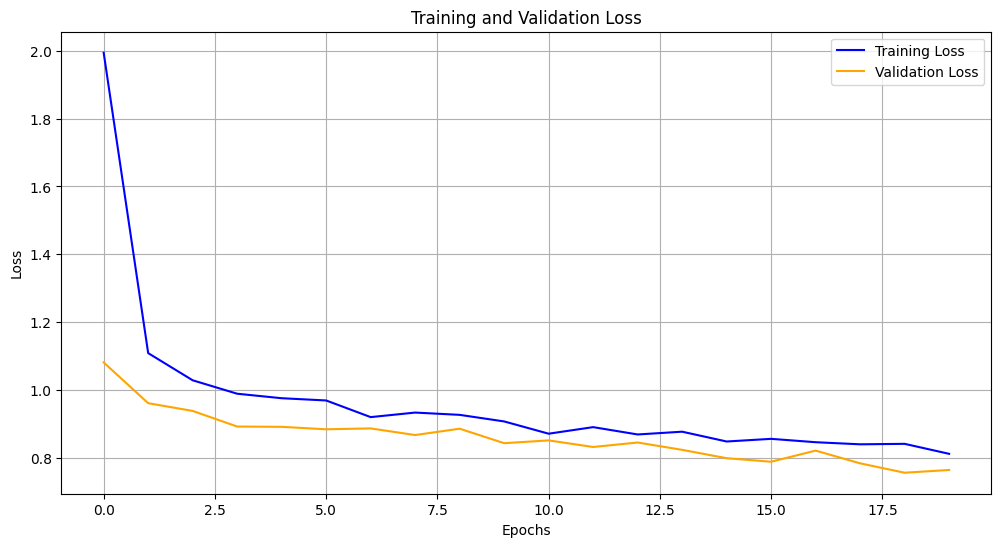

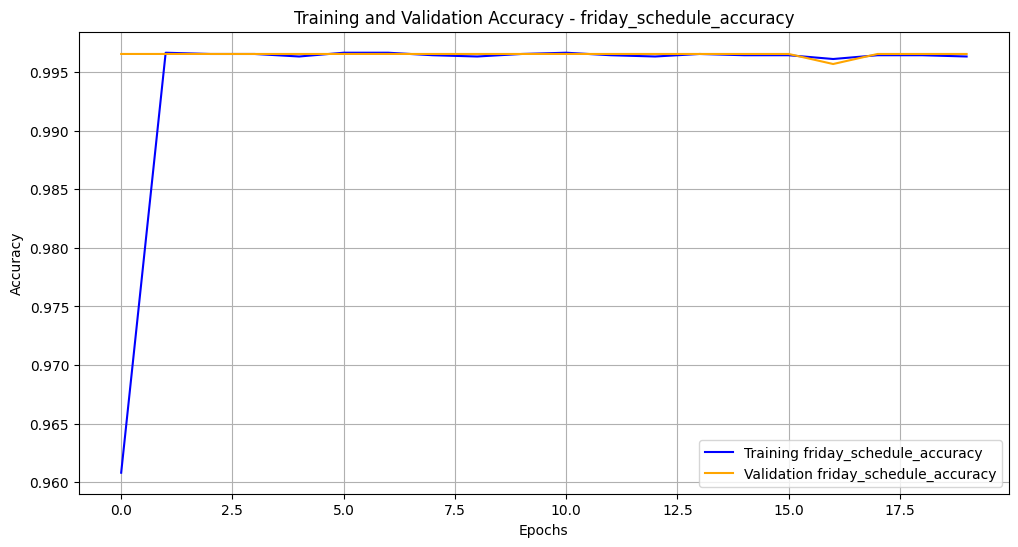

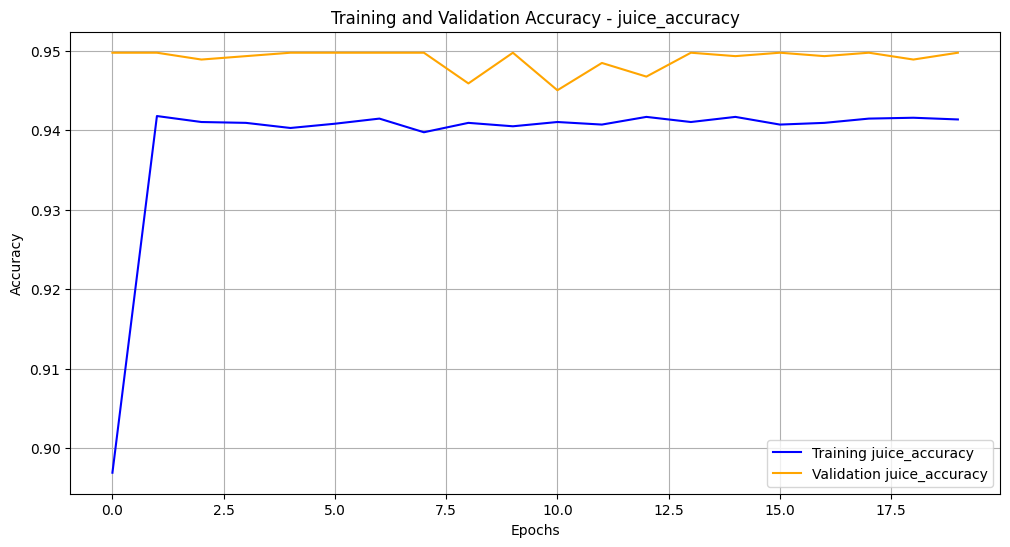

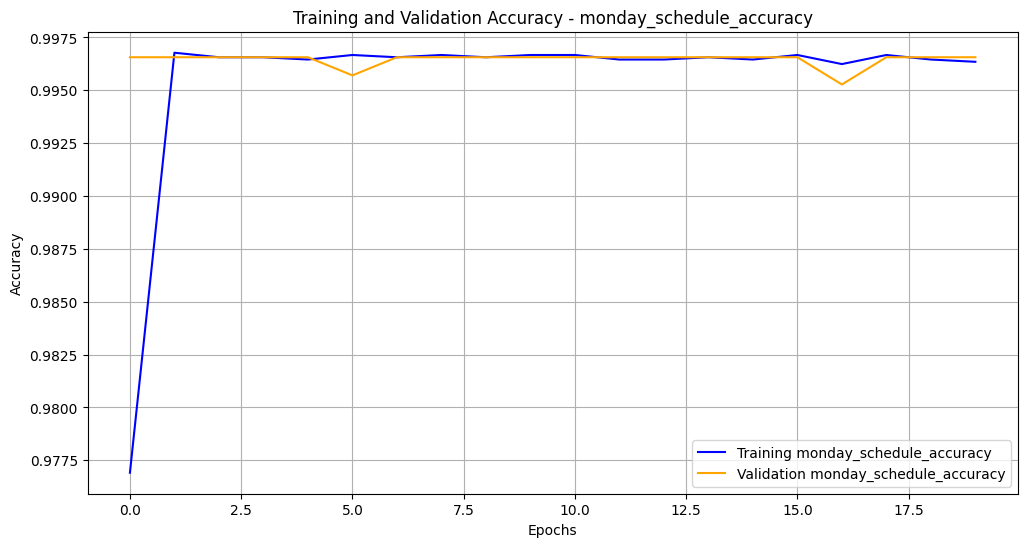

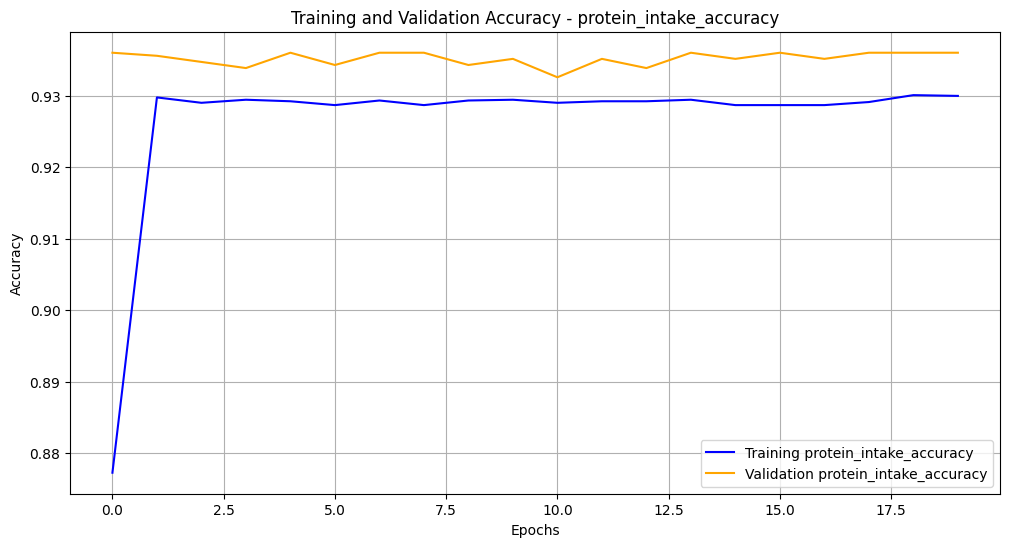

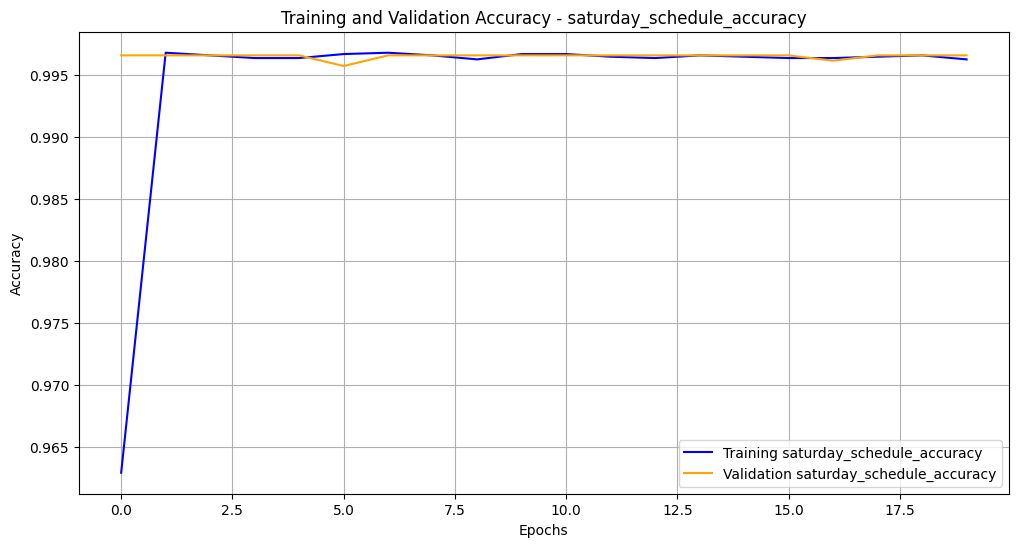

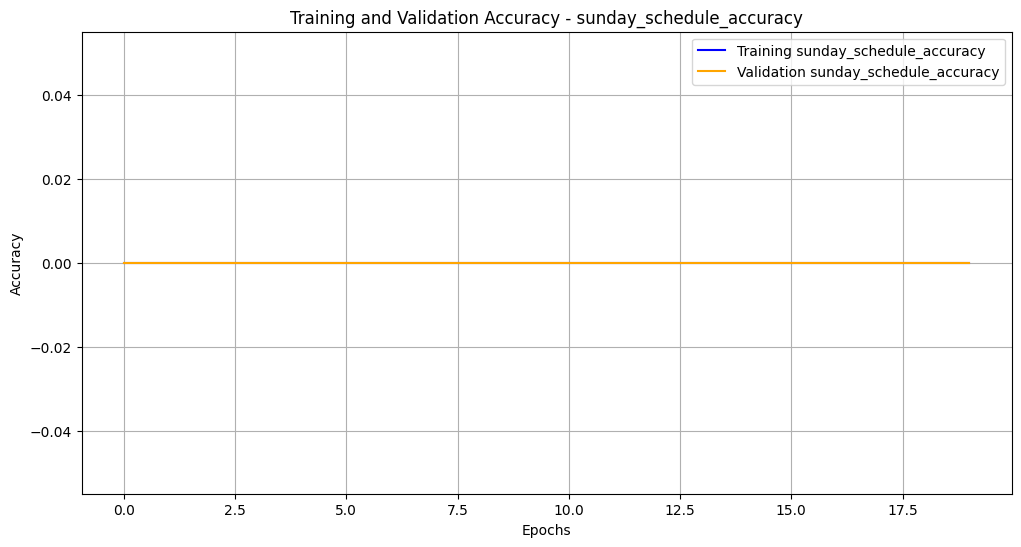

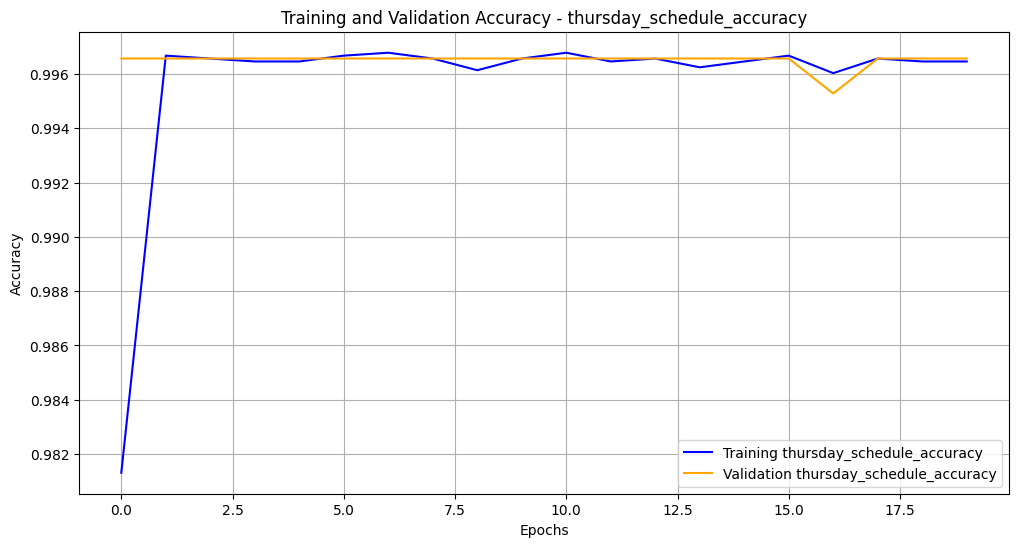

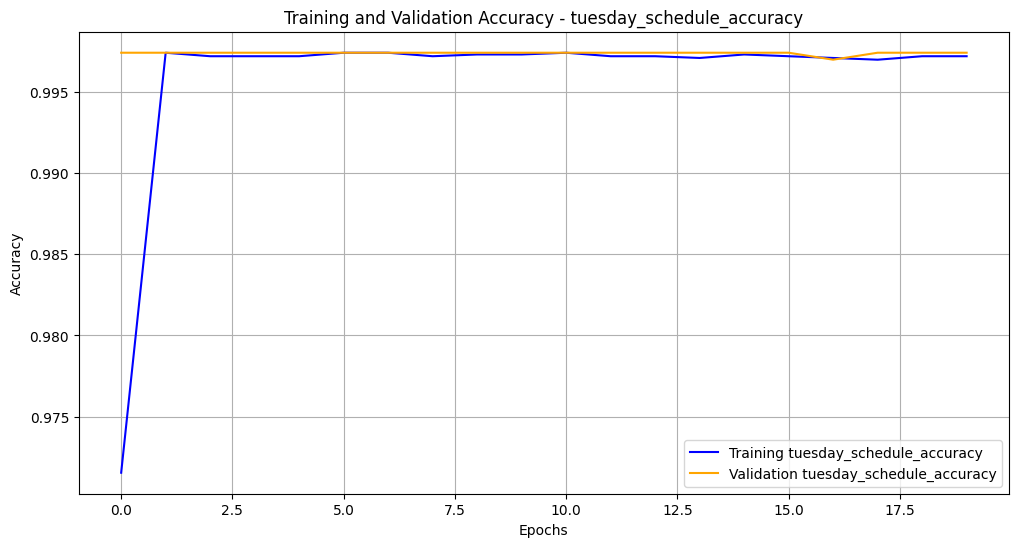

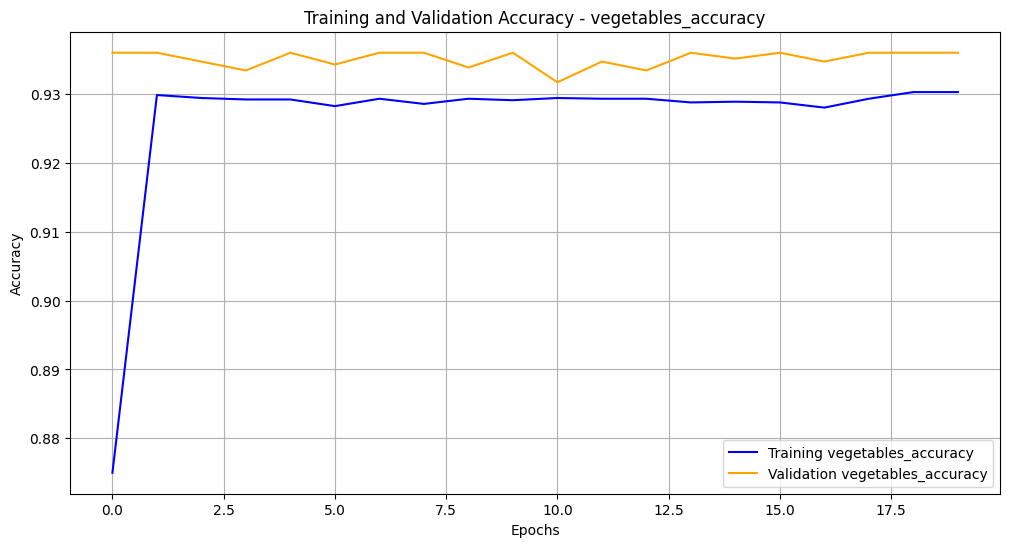

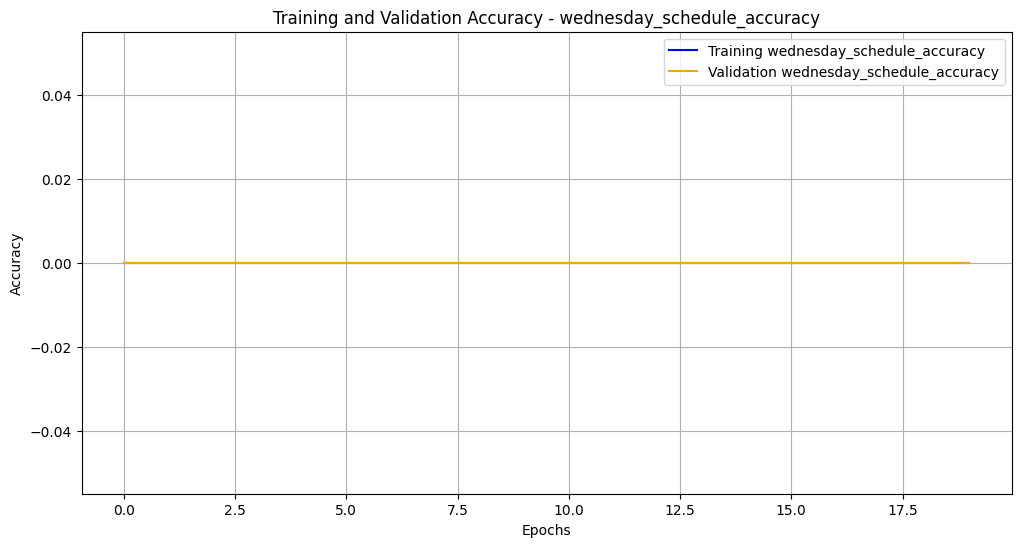

In [16]:
# Take data from history
history_dict = history.history

# Loss Graph
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Graph (each output)
output_columns_graph = [col for col in history_dict.keys() if 'accuracy' in col and 'val_' not in col]
for output in output_columns_graph:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[output], label=f'Training {output}', color='blue')
    plt.plot(history_dict[f'val_{output}'], label=f'Validation {output}', color='orange')
    plt.title(f'Training and Validation Accuracy - {output}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Save Model and Preprocessor**

In [17]:
# Save the model
model.save('gym_and_diet_model.h5')

### **Convert Model**

In [19]:
# Install tensorflowjs
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [1]:
!tensorflowjs_converter --input_format=keras \
gym_and_diet_model.h5 \
./tfjs_model

2024-12-11 16:33:38.737517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733934818.864660    2716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733934818.921001    2716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 16:33:38.989926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed

### **Example Prediction**

In [18]:
# Load the trained model
model = load_model('gym_and_diet_model.h5')

# Example new data for prediction
new_data = pd.DataFrame({
    'gender': ['pria'],
    'age': [22],
    'height': [170],
    'weight': [95.0],
    'BMI': [32.90],
    'hypertension_status': ['tidak'],
    'diabetes_status': ['tidak'],
    'user_obesity_level': ['Obesity_Type_I'],
    'fitness_goal': ['Weight Loss'],
    'fitness_type': ['Cardio Fitness']
})

# Preprocess the new data
# One-hot encode categorical columns
categorical_columns1 = ["gender", "hypertension_status", "diabetes_status", "fitness_goal", "fitness_type"]
new_data_encoded = onehot_encoder.transform(new_data[categorical_columns1])  # Use the previously fitted encoder
new_data_encoded_df = pd.DataFrame(new_data_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns1))
new_data = pd.concat([new_data, new_data_encoded_df], axis=1)

# Label encode categorical columns
new_data["user_obesity_level"] = label_encoder["user_obesity_level"].transform(new_data["user_obesity_level"])  # Use the previously fitted encoder

# Normalize numerical columns
new_data[['age', 'height', 'weight', 'BMI']] = scaler.transform(new_data[['age', 'height', 'weight', 'BMI']])  # Use the previously fitted scaler

# Select features for prediction
X_new = new_data[input_columns]

# Predict the outputs
predictions = model.predict(X_new)

decoded_predictions = {}
for i, output in enumerate(output_columns):
    # Use the encoder specific to the current output column for inverse transform
    decoded_predictions[output] = label_encoder[output].inverse_transform([np.argmax(predictions[i])])[0]

# Print predictions
for key, value in decoded_predictions.items():
    print(f"{key}: {value}")

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
vegetables: brokoli, wortel, bayam, selada, bawang bombai
protein_intake: keju, keju cottage, susu skim, susu rendah lemak, kacang tanah
juice: jus buah, jus lidah buaya, jus cold pressed, jus semangka
monday_schedule: jalan cepat (30 menit)
tuesday_schedule: bersepeda (30 menit)
wednesday_schedule: istirahat
thursday_schedule: berenang (20 menit)
friday_schedule: lari (20 menit)
saturday_schedule: senam (30 menit)
sunday_schedule: istirahat
